In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
ins_data = pd.read_csv('Insurance_Company_Complaints__Resolutions__Status__and_Recoveries.csv')

# To explore futher: 
* was the conclusion always 'justified' with a recovery? How many corrective actions were involved?
* Does this mean that an employee was negligent, at-fault, etc? Was the company itself reprimanded? 
* How many unfair claims practices were justified and what was their average recovery amount? 
* For chadwell: what is the most "alarming" reason for complaint for an insurer to receive, if it were to be justified?
* From a legal standpoint - would unfair claims practice come with the biggest possible lawsuit? Show Chadwell the list of Reasons and Subreasons
* Average length of time a case was open?

# After EDA/Visualization
* Generate a Hypothesis based on the data
* Use glassdoor sample data to test the hypothesis
* Perhaps load webscraped data into a SQL database? Mongo?
    * Glassdoor has an API - should I still webscrape to demonstrate this skill? 
* Look at the overall stats of reviews: 
    * Do the reviews follow a normal distribution? 
    * Are the results skewed towards positive or negative reviews?
    * Note this as a consideration in regards to whether the sample is i.i.d (are disgruntled employees posting more/less overall?)
* Are my findings similar to other studies that have looked at employee satisfaction vs customer satisfaction?

# Look at the published financials of the top 5 companies
* price per claims
* loss ratios
* Actuarily data
* Where are they making money, what do they tend to underwrite (what is their bread and butter service)
* It gets messy because a life insurance company can have different metrics than an auto company
* Might want to consider grouping by policy type
    * Anthem and ConnectiCare are two top Health Insurance companies
    
# Things to plot: 
* Categorical bar charts = figure out how to do so with OOP
* Claim duration vs recovery amount
* average recovery amount by conclusion type
* average recovery amount by company
* max recovery amount by conclusion type and by company
* same stats by reason 

In [4]:
ins_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14509 entries, 0 to 14508
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      14509 non-null  object 
 1   File No.     14509 non-null  int64  
 2   Opened       14509 non-null  object 
 3   Closed       14078 non-null  object 
 4   Coverage     11915 non-null  object 
 5   SubCoverage  4879 non-null   object 
 6   Reason       14509 non-null  object 
 7   SubReason    14509 non-null  object 
 8   Disposition  14130 non-null  object 
 9   Conclusion   14130 non-null  object 
 10  Recovery     14509 non-null  float64
 11  Status       14509 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.3+ MB


In [5]:
# It looks like Insurance companies rarely pay out after a complaint, but when they do, the payout is very large
ins_data.describe()

,File No.,Recovery
count,14509.000000,14509.000000
mean,725908.174168,1331.318662
std,107689.450113,15838.502857
min,100831.000000,0.000000
25%,604805.000000,0.000000
50%,704227.000000,0.000000
75%,803691.000000,0.000000
max,902841.000000,843825.850000


In [6]:
# It appears that most NAN values are in Coverage or SubCoverage columns. These aren't relevant to the questions
# I'm exploring, so I will leave these unless they need to be dropped for a particular query. 
ins_data[ins_data.isna().any(axis=1)]

,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
1,21st Century Insurance Company,505848,12/31/2015,01/25/2016,Auto,NaN,Marketing/Sales,Producer Handling,Company Position Upheld,Unjustified,0.00,Closed
2,21st Century Insurance Company,601543,04/01/2016,08/12/2016,Auto,NaN,Underwriting,Cancellation,Insufficient Information,No Action Necessary,0.00,Closed
4,Allstate Fire and Casualty Insurance Company,803285,07/18/2018,08/06/2018,Auto,NaN,Premium and Rating,Premium Refund Delay,Corrective Action,Justified,95.59,Closed
5,National Life Insurance Company,902099,05/09/2019,NaN,Individual Life,Universal Life,Marketing/Sales,Producer Handling,NaN,NaN,0.00,Open
6,"Anthem Health Plans, Inc",901887,04/25/2019,05/13/2019,NaN,NaN,Underwriting,Cancellation,Coverage Granted,Justified,0.00,Closed
...,...,...,...,...,...,...,...,...,...,...,...,...
14498,"Anthem Health Plans, Inc",802680,06/08/2018,06/25/2018,NaN,NaN,Utilization Review,UR Procedure,Med Jurisdiction Explained,Furnished Information,0.00,Closed
14500,UnitedHealthcare Insurance Company,802854,06/20/2018,06/26/2018,NaN,NaN,Unfair Claims Practice,CPT Code Issue,Claim Settled,Furnished Information,159.36,Closed
14501,Bankers Life and Casualty Company,802634,06/06/2018,06/26/2018,NaN,NaN,Unfair Claims Practice,Claim Delays,Furnished Information,Furnished Information,0.00,Closed
14502,"Anthem Health Plans, Inc",802380,05/21/2018,06/26/2018,NaN,NaN,Unfair Claims Practice,Claim Procedure,Claim Settled,Furnished Information,804.50,Closed


In [8]:
# There are 14509 in the dataset, but only 10712 File No., indicating there are duplicate entries that 
# should be dropped
ins_data.nunique()

623

In [364]:
# 6480 duplicate records, should be 3797... got to 3418 and am going with it. 
# Kept the last file, as most duplicate sets of files contained coverage info in the second entry
# pulled the duplicate records from the set of duplicates, found the entries with NAN, checked to see if there was a
# corresponding duplicate file in the original dataset, added those records back in 
duplicate_records = ins_data[ins_data.duplicated('File No.', keep = 'first')].sort_values('File No.', ascending=False)
files = ins_data['File No.']
unique_records = ins_data[~ins_data.duplicated(subset=['File No.'], keep=False)]
# ins_data[files.isin(files[files.duplicated()])].sort_values("File No.").head(50)
# isnull count when keeping the last record: 1046, when keeping first = 1607
duplicate_records[duplicate_records['Coverage'].isnull()]
ins_data[ins_data['Coverage'].isnull()]

# CONCLUSION - group by coverage type, then drop duplicates... 

,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
6,"Anthem Health Plans, Inc",901887,04/25/2019,05/13/2019,NaN,NaN,Underwriting,Cancellation,Coverage Granted,Justified,0.00,Closed
8,Liberty Insurance Corporation,803184,07/11/2018,08/06/2018,NaN,NaN,Premium and Rating,Premium Refund Delay,Corrective Action,Justified,924.00,Closed
35,"ConnectiCare Insurance Company, Inc",902445,05/31/2019,06/14/2019,NaN,NaN,Unfair Claims Practice,Provider Contract Issue,Claim Settled,Furnished Information,13627.00,Closed
49,Bankers Life and Casualty Company,902492,06/03/2019,06/14/2019,NaN,NaN,Unfair Claims Practice,Claim Delays,Furnished Information,Furnished Information,0.00,Closed
64,ConnectiCare Inc,804381,09/17/2018,10/03/2018,NaN,NaN,Utilization Review,Medical Necessity,External Review Info Sent,Furnished Information,0.00,Closed
...,...,...,...,...,...,...,...,...,...,...,...,...
14498,"Anthem Health Plans, Inc",802680,06/08/2018,06/25/2018,NaN,NaN,Utilization Review,UR Procedure,Med Jurisdiction Explained,Furnished Information,0.00,Closed
14500,UnitedHealthcare Insurance Company,802854,06/20/2018,06/26/2018,NaN,NaN,Unfair Claims Practice,CPT Code Issue,Claim Settled,Furnished Information,159.36,Closed
14501,Bankers Life and Casualty Company,802634,06/06/2018,06/26/2018,NaN,NaN,Unfair Claims Practice,Claim Delays,Furnished Information,Furnished Information,0.00,Closed
14502,"Anthem Health Plans, Inc",802380,05/21/2018,06/26/2018,NaN,NaN,Unfair Claims Practice,Claim Procedure,Claim Settled,Furnished Information,804.50,Closed


## Looking at the contents of various columns

In [9]:
ins_data['Reason'].unique()

array(['Unfair Claims Practice', 'Marketing/Sales', 'Underwriting',
       'Premium and Rating', 'Utilization Review', 'FOI Inquiry',
       'Unknown', 'Employer Handling', 'Statute Violation', 'Other',
       'No Jurisdiction', 'Retro Review'], dtype=object)

In [10]:
ins_data['SubReason'].unique()

array(['Claim Delays', 'Producer Handling', 'Cancellation',
       'Policy Service', 'Premium Refund Delay',
       'Unsatisfactory Settlement', 'Premium/Rate Increase',
       'Denial of Claim', 'Premium/Notice', 'Medical Necessity',
       'Provider Contract Issue', 'Claim Procedure',
       'Unsatisfactory Offer', 'Non-Renewal', 'Actual Cash Value Dispute',
       'Eligibility of Provider', 'Contract Provision', 'No Subreason',
       'Policy Service Delay', 'Coordination of Benefit',
       'Misrepresentation', 'Excessive Charges', 'Loss of Use',
       'CPT Code Issue', 'Misleading Advertising',
       'Comparative Negligence', 'Failed to Remit Premium', 'Subrogation',
       'Diminished Value', 'Audit', 'UR Procedure', 'Refusal to Insure',
       'Other [Enter Sub-Reason]', 'Time Delay',
       'No Coverage/Premium Paid', 'Discontinuation & Replmnt',
       'Mandated Benefit', 'Case Management', 'Other Fees', 'Replacement',
       'Labor Rate', 'Delays', 'Usual and Customary Fees

In [11]:
ins_data['Conclusion'].unique()

array(['Unjustified', 'No Action Necessary', 'Justified', nan,
       'Questionable', 'Furnished Information', 'Voluntary Reconsider',
       'No Authority', 'Cross Reference Only'], dtype=object)

In [372]:
company_complaints = ins_data[['Company', 'Coverage']].groupby(['Company', 'Coverage']).count().sort_values('File No.', ascending=False)
# confirming correct code
# company_complaints = ins_data['Company'].value_counts()
company_complaints

KeyError: 'File No.'

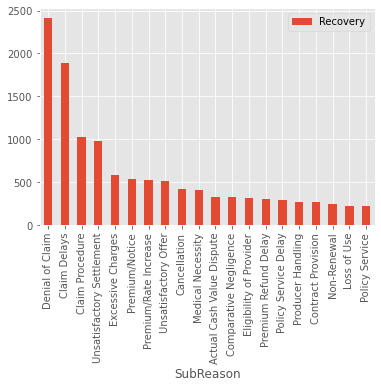

In [412]:
sub_reason_counts = ins_data[['SubReason', 'Recovery']].groupby('SubReason').count().reset_index()
disposition_counts = ins_data['Disposition'].value_counts()

sub_reason_counts = sub_reason_counts.sort_values('Recovery', ascending=False).head(20)

# fig, ax = plt.subplots(figsize=(10,10))
sub_reason_counts.plot.bar(x='SubReason', y='Recovery')
# ax.plot()
# ax = sns.barplot(x='SubReason', y='Recovery', data=sub_reason_counts, palette='pastel', saturation=1)
# ax.set_title('Companies with Most Complaints')
# ax.set_xticklabels(x, rotation=45)
# ax.set_ylabel('Complaints');

In [13]:
# Looking at 'significantly sized' recovery amounts (I chose a number arbitrarily)
some_recovery = ins_data[ins_data['Recovery'] > 20000]
some_recovery.sort_values('Recovery', ascending=False)


,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
3013,GEICO General Insurance Company,801471,03/26/2018,08/28/2018,Auto,NaN,Premium and Rating,Excessive Charges,Corrective Action,Justified,843825.85,Closed
11333,"Anthem Health Plans, Inc",601355,03/22/2016,03/30/2016,Individual Health,Air Ambulance,Utilization Review,Medical Necessity,Coverage Granted,Justified,838039.00,Closed
11121,"Anthem Health Plans, Inc",601355,03/22/2016,03/30/2016,NaN,NaN,Utilization Review,Medical Necessity,Coverage Granted,Justified,838039.00,Closed
12264,"Cigna HealthCare of Connecticut, Inc",405073,10/14/2014,04/29/2016,Group Health,Anesthesia,Unfair Claims Practice,Unsatisfactory Settlement,Claim Settled,Justified,404171.32,Closed
8927,State Farm Fire & Casualty Company,901019,03/01/2019,04/01/2019,Homeowners,NaN,Unfair Claims Practice,Claim Delays,Claim Settled,Justified,305000.00,Closed
...,...,...,...,...,...,...,...,...,...,...,...,...
2142,Carolina Casualty Insurance Company,600423,01/28/2016,03/17/2016,Worker's Compensation,NaN,Premium and Rating,Audit,Corrective Action,Justified,20608.00,Closed
10920,Underwriters at Lloyds London,702445,05/24/2017,07/18/2017,Travel Insurance,NaN,Unfair Claims Practice,Claim Procedure,Claim Settled,Furnished Information,20213.75,Closed
12801,Empire Fire and Marine Insurance Company,800695,02/09/2018,03/09/2018,Auto Liability,NaN,Unfair Claims Practice,Actual Cash Value Dispute,Corrective Action,Justified,20208.59,Closed
4201,"Anthem Health Plans, Inc",703224,07/17/2017,07/28/2017,Ind Medicare Supplemental,No SubCov - AH,Unfair Claims Practice,Claim Procedure,Claim Settled,Furnished Information,20085.09,Closed


In [14]:
# There were a surprising number of cases still open. Check to see when this dataset was last updated
ins_data.groupby('Status').count()
ins_data[ins_data['Status'] == 'Open']

,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
5,National Life Insurance Company,902099,05/09/2019,NaN,Individual Life,Universal Life,Marketing/Sales,Producer Handling,NaN,NaN,0.0,Open
19,"Anthem Health Plans, Inc",902658,06/13/2019,NaN,NaN,NaN,Unfair Claims Practice,Provider Contract Issue,NaN,NaN,0.0,Open
20,Lincoln National Life Insurance Company (The),902672,06/14/2019,NaN,NaN,NaN,Unfair Claims Practice,Claim Procedure,NaN,NaN,0.0,Open
23,"ConnectiCare Benefits, Inc.",902657,06/13/2019,NaN,Exchange-Individual Hlth,High Deductible Hlth Plan,Premium and Rating,Premium/Notice,NaN,NaN,0.0,Open
88,National Life Insurance Company,902099,05/09/2019,NaN,NaN,NaN,Marketing/Sales,Producer Handling,NaN,NaN,0.0,Open
...,...,...,...,...,...,...,...,...,...,...,...,...
13904,New London County Mutual Insurance Company,902053,05/07/2019,NaN,Homeowners,NaN,Underwriting,Non-Renewal,NaN,NaN,0.0,Open
13919,Allstate Insurance Company,802282,05/14/2018,NaN,Homeowners,NaN,Premium and Rating,Excessive Charges,NaN,NaN,0.0,Open
13939,"ConnectiCare Benefits, Inc.",902112,05/09/2019,NaN,Exchange-Individual Hlth,Birth Control,Unfair Claims Practice,Denial of Claim,NaN,NaN,0.0,Open
14032,GEICO Casualty Company,902105,05/09/2019,NaN,Auto Physical Damage,NaN,Unfair Claims Practice,Denial of Claim,NaN,NaN,0.0,Open


In [15]:
# Disposition I assume is the company response. Counting those values and finding the top entries. 
# To explore: patterns with Refer-Judicial/Attorney
disposition_df = ins_data.groupby('Disposition').count().sort_values('File No.', ascending=False)
disposition_df.head(20)

,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Conclusion,Recovery,Status
Disposition,,,,,,,,,,,
Company Position Upheld,3947,3947,3947,3931,3355,467,3947,3947,3947,3947,3947
Claim Settled,1736,1736,1736,1731,1374,547,1736,1736,1736,1736,1736
Furnished Information,1564,1564,1564,1561,1234,1170,1564,1564,1564,1564,1564
Contract Provision,1460,1460,1460,1452,1188,632,1460,1460,1460,1460,1460
Corrective Action,1340,1340,1340,1339,1100,349,1340,1340,1340,1340,1340
Refer-Judicial/Attorney,513,513,513,511,430,2,513,513,513,513,513
Rate Increase Explained,276,276,276,275,244,244,276,276,276,276,276
Premium Refund,259,259,259,259,221,107,259,259,259,259,259
Enter Arbitration,255,255,255,253,227,0,255,255,255,255,255


In [16]:
# Check the top companies to make sure they handle a similar number of claims each year - is the dataset "i.i.d",
# so to speak? 


# 623 distinct companies
ins_data['Company'].unique()

# Top 5 companies: Anthem Health Plans, ConnectiCare, Allstate, Geico, United
company_count = ins_data[['Company', 'File No.']].groupby('Company').count() \
                            .sort_values('File No.', ascending=False) \
                                .rename(columns={'File No.': 'Complaints Filed'})
# Checking to make sure the above command was correction. The sum of the counts == num rows. 
company_count['Complaints Filed'].sum()

# Ask Brian what a good normalizing number would be to compare the size of these companies and normalize for that.
# Revenue per year? Claims filed (if that number is even available)? Something from the stock market?
# Use Value at risk to normalize data
# Or, use something about expected payout? 

14509

In [285]:
# From dataset
Top_5 = ['Anthem', 'ConnectiCare', 'Allstate', 'Geico', 'United']

# 2018 net premiums for each of the companies above, to be used to normalize the dataset. 
# Source: https://www.reinsurancene.ws/worlds-largest-insurance-companies/
Top_5_premiums = {'Anthem': 85048000, 'United': 178087000}

In [112]:
reason = ins_data['Reason'].value_counts()
conclusion = ins_data['Conclusion'].value_counts()
reason

Unfair Claims Practice    9388
Premium and Rating        2120
Marketing/Sales           1456
Underwriting               817
Utilization Review         581
FOI Inquiry                 60
Employer Handling           35
Other                       22
Statute Violation           14
Unknown                      9
No Jurisdiction              6
Retro Review                 1
Name: Reason, dtype: int64

<class 'pandas.core.series.Series'>


<BarContainer object of 8 artists>

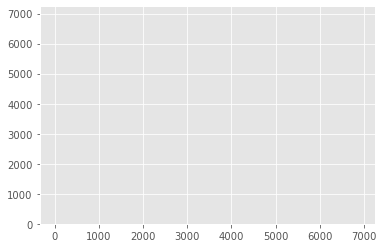

In [108]:
# barplots of 'Reason', 'Conclusion'

import matplotlib.pyplot as plt
import numpy as np


labels = Top_5
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# Exploring complaints that were referred to legal counsel
* CRS 
* Trebel damages 

In [414]:
# Disposition - Refer/Judicial
# How many cases that were referred to Judicial were concluded in favor of the insured? 
# What was the average duration of these cases? What might this cost (find source for this)
# What was the most common reason/subreason for the complaint within this subgroup? 
# How many ended with recovery and what was the average payout? Higher or lower than without counsel? 
# For Chadwell - if the insured were to win a denial of claim vs comp neg case, which would likely have the higher
# payout, and by how much?
# Is a denial of claim likely just a small claims case? 


judicial_df = ins_data[ins_data['Disposition'] == 'Refer-Judicial/Attorney' \
                       and ins_data['SubReason']=='Corrective Action']
# grp_jud_df = judicial_df.groupby('Company') \
#                 .agg({'Recovery': 'mean', ''})

# df = df.groupby('source') \
#        .agg({'text':'size', 'sent':'mean'}) \
#        .rename(columns={'text':'count','sent':'mean_sent'}) \
#        .reset_index()
judicial_df.sort_values('Recovery', ascending = False)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [18]:
# Which have the most justified complaints?
y = ins_data[ins_data['Conclusion'] == 'Justified'].reset_index()

y[['Company', 'Conclusion']].groupby('Company').count().sort_values('Conclusion', ascending=False)

,Conclusion
Company,
"Anthem Health Plans, Inc",198
UnitedHealthcare Insurance Company,74
Allstate Fire and Casualty Insurance Company,62
LM General Insurance Company,57
"ConnectiCare Insurance Company, Inc",49
...,...
Narragansett Bay Insurance Company,1
Minnesota Life Insurance Company,1
American Zurich Insurance Company,1


In [19]:
# which have the most corrective action? (There are 623 companies)
# add column that shows the recovery amount sum per company for CA
z = ins_data[['Company', 'Disposition']]
corrective_act_count = z[z['Disposition'] == 'Corrective Action'].groupby('Company').count() \
                        .sort_values(by='Disposition', ascending=False).reset_index()
corrective_act_count = corrective_act_count.rename(columns={'Disposition': 'Corrective Action Count'})
corrective_act_count

,Company,Corrective Action Count
0,"Anthem Health Plans, Inc",59
1,Allstate Fire and Casualty Insurance Company,46
2,LM General Insurance Company,38
3,GEICO General Insurance Company,33
4,State Farm Mutual Automobile Insurance Company,29
...,...,...
254,"Paratransit Insurance Company, A Mutual Risk R...",1
255,Genworth Life Insurance Company,1
256,Genworth Life and Annuity Insurance Company,1
257,Old Republic Insurance Company,1


In [20]:
# Insert column that shows the ratio of CA Counts / total complaints filed

corrective_act_count = 


SyntaxError: invalid syntax (<ipython-input-20-72a29c6448fc>, line 3)

# Grouping by policy type
- I don't want to aggregate over the column, but instead just look at data in coverage type buckets
- Perhaps groupby is not the best choice
- There are 69 unique coverage types
- Can any of these coverage types be collapsed? (Auto Liability, Auto, Auto Physical Damage, for example)
- SubCoverage had relatively few entries
- Insurance pays on property damage easily (rarely does this go into litigation)
- The real liability risk is bodily injury
- Chadwell: Auto liability includes property damage and BI
- General liability with umbrella policies are a big risk to insurers because they cover pretty much everything

In [21]:
ins_data['Coverage'].nunique()
ins_data[['Coverage', 'Company']].groupby('Coverage').count().sort_values('Company', ascending=False).head(20)

,Company
Coverage,
Auto Liability,2335
Homeowners,1610
Group Health,1442
Auto Physical Damage,915
Auto,852
Individual Health,738
Exchange-Individual Hlth,600
Individual Life,556
Individual Long Term Care,430


# Exploring all 'Auto' related coverage types

In [114]:
auto_df = ins_data[ins_data['Coverage'].notna()]
auto_df = auto_df[auto_df['Coverage'].str.contains('Auto')]
auto_df.head(2)

,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
1,21st Century Insurance Company,505848,12/31/2015,01/25/2016,Auto,NaN,Marketing/Sales,Producer Handling,Company Position Upheld,Unjustified,0.0,Closed
2,21st Century Insurance Company,601543,04/01/2016,08/12/2016,Auto,NaN,Underwriting,Cancellation,Insufficient Information,No Action Necessary,0.0,Closed


In [299]:
ins_data['Conclusion'].unique()

array(['Unjustified', 'No Action Necessary', 'Justified', 'Questionable',
       'Furnished Information', 'Voluntary Reconsider', 'No Authority',
       'Cross Reference Only'], dtype=object)

In [149]:
# Can I lump Geico General and Idemnity together? Likely no because they write different type of policies
# Causalty would be property
top_5_auto = auto_df['Company'].value_counts()[0:5]
top_5_auto = top_5_auto.to_frame().reset_index()

top_5_auto = top_5_auto.rename(columns={'index':'Company', 'Company':'No. Complaints'})
top_5_auto

,Company,No. Complaints
0,Allstate Fire and Casualty Insurance Company,412
1,GEICO General Insurance Company,305
2,GEICO Indemnity Company,257
3,Progressive Direct Insurance Company,232
4,Progressive Casualty Insurance Company,210


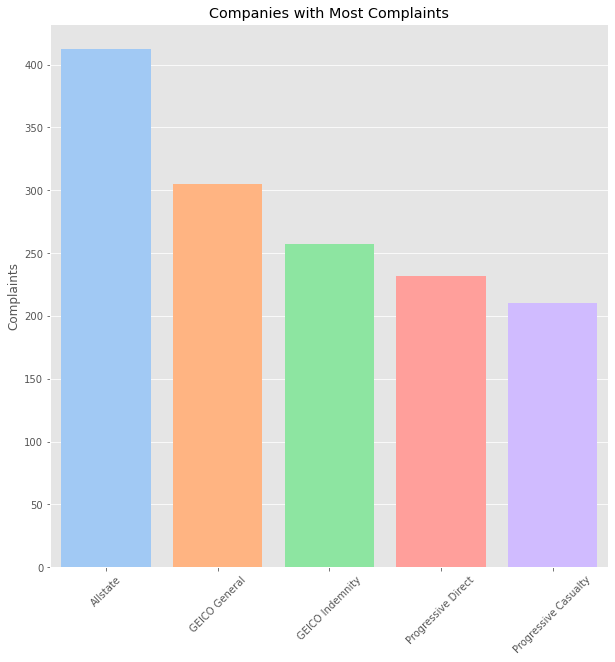

In [301]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
bars = list(range(5))
x = ['Allstate', 'GEICO General', 'GEICO Indemnity', 'Progressive Direct', 'Progressive Casualty']
ax = sns.barplot(x=x, y='No. Complaints', data=top_5_auto, palette='pastel', saturation=1)
ax.set_title('Companies with Most Complaints')
ax.set_xticklabels(x, rotation=45)
ax.set_ylabel('Complaints');

In [1]:
# Within auto complaints, Unfair claims practice is attributable to the the largest total recovery amount
auto_df.groupby('SubReason').sum().sort_values('Recovery', ascending=False)

NameError: name 'auto_df' is not defined

# Exploring time

In [25]:
ins_data.head(10)

,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
0,Transamerica Life Insurance Company,803396,07/24/2018,08/06/2018,Credit A & H,No SubCov - AH,Unfair Claims Practice,Claim Delays,Company Position Upheld,Unjustified,0.00,Closed
1,21st Century Insurance Company,505848,12/31/2015,01/25/2016,Auto,NaN,Marketing/Sales,Producer Handling,Company Position Upheld,Unjustified,0.00,Closed
2,21st Century Insurance Company,601543,04/01/2016,08/12/2016,Auto,NaN,Underwriting,Cancellation,Insufficient Information,No Action Necessary,0.00,Closed
3,Prudential Insurance Company of America,805351,11/14/2018,12/04/2018,Individual Life,Whole Life,Marketing/Sales,Policy Service,Company Position Upheld,Unjustified,0.00,Closed
4,Allstate Fire and Casualty Insurance Company,803285,07/18/2018,08/06/2018,Auto,NaN,Premium and Rating,Premium Refund Delay,Corrective Action,Justified,95.59,Closed
5,National Life Insurance Company,902099,05/09/2019,NaN,Individual Life,Universal Life,Marketing/Sales,Producer Handling,NaN,NaN,0.00,Open
6,"Anthem Health Plans, Inc",901887,04/25/2019,05/13/2019,NaN,NaN,Underwriting,Cancellation,Coverage Granted,Justified,0.00,Closed
7,Standard Fire Insurance Company (The),803122,07/06/2018,08/06/2018,Auto,NaN,Marketing/Sales,Producer Handling,Corrective Action,Questionable,0.00,Closed
8,Liberty Insurance Corporation,803184,07/11/2018,08/06/2018,NaN,NaN,Premium and Rating,Premium Refund Delay,Corrective Action,Justified,924.00,Closed
9,"Anthem Health Plans, Inc",802871,06/21/2018,08/06/2018,Group Health,Emergency,Unfair Claims Practice,Unsatisfactory Settlement,Contract Provision,Furnished Information,0.00,Closed


In [4]:
# Inspecting an element from the opened column shows the dates are cast as strings. 
dt_df = ins_data[ins_data['Opened'].notna()]
type(dt_df['Closed'][0])

dt_df['Closed']= pd.to_datetime(dt_df['Closed'])
dt_df['Opened']= pd.to_datetime(dt_df['Opened'])



NameError: name 'ins_data' is not defined

In [227]:
# Adding new column
dt_df['Claim Duration'] = dt_df['Closed'] - dt_df['Opened']
dt_df['Claim Duration'] = (dt_df['Claim Duration'] / np.timedelta64(1, 'M')).round(2)
dt_df = dt_df.drop('Claim Duration', axis=1)
dt_df

,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status,Complaint Duration
0,Transamerica Life Insurance Company,803396,2018-07-24,2018-08-06,Credit A & H,No SubCov - AH,Unfair Claims Practice,Claim Delays,Company Position Upheld,Unjustified,0.00,Closed,0.43
1,21st Century Insurance Company,505848,2015-12-31,2016-01-25,Auto,NaN,Marketing/Sales,Producer Handling,Company Position Upheld,Unjustified,0.00,Closed,0.82
2,21st Century Insurance Company,601543,2016-04-01,2016-08-12,Auto,NaN,Underwriting,Cancellation,Insufficient Information,No Action Necessary,0.00,Closed,4.37
3,Prudential Insurance Company of America,805351,2018-11-14,2018-12-04,Individual Life,Whole Life,Marketing/Sales,Policy Service,Company Position Upheld,Unjustified,0.00,Closed,0.66
4,Allstate Fire and Casualty Insurance Company,803285,2018-07-18,2018-08-06,Auto,NaN,Premium and Rating,Premium Refund Delay,Corrective Action,Justified,95.59,Closed,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14504,"Anthem Health Plans, Inc",802380,2018-05-21,2018-06-26,Dental,Dental,Unfair Claims Practice,Claim Procedure,Claim Settled,Furnished Information,804.50,Closed,1.18
14505,Cigna Health and Life Insurance Company,701453,2017-03-24,2017-05-22,Group Health,Autism,Unfair Claims Practice,Eligibility of Provider,No Cause For Action,No Action Necessary,0.00,Closed,1.94
14506,UnitedHealthcare Insurance Company,802854,2018-06-20,2018-06-26,Group Health,Prescription,Unfair Claims Practice,CPT Code Issue,Claim Settled,Furnished Information,159.36,Closed,0.20
14507,Federal Insurance Company,802352,2018-05-17,2018-06-15,A & H,Maternity,Marketing/Sales,Misrepresentation,Furnished Information,Furnished Information,4018.90,Closed,0.95


In [228]:
# Why would there be two file numbers? 
dt_df[dt_df['Recovery'] > 2000].sort_values('Complaint Duration', ascending = False).head(10)

,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status,Complaint Duration
8135,"Anthem Health Plans, Inc",404944,2014-10-02,2017-04-26,NaN,NaN,Unfair Claims Practice,Claim Delays,Claim Settled,Justified,75844.76,Closed,30.79
10064,"Anthem Health Plans, Inc",404944,2014-10-02,2017-04-26,Exchange-Individual Hlth,Autism,Unfair Claims Practice,Claim Delays,Claim Settled,Justified,75844.76,Closed,30.79
9969,"Anthem Health Plans, Inc",500440,2015-02-03,2016-11-09,Exchange-Individual Hlth,Out-Patient,Unfair Claims Practice,CPT Code Issue,Claim Paid With Interest,Justified,49924.93,Closed,21.19
12264,"Cigna HealthCare of Connecticut, Inc",405073,2014-10-14,2016-04-29,Group Health,Anesthesia,Unfair Claims Practice,Unsatisfactory Settlement,Claim Settled,Justified,404171.32,Closed,18.50
14153,"Anthem Health Plans, Inc",605709,2016-12-15,2018-06-01,Exchange-Individual Hlth,Ambulance,Unfair Claims Practice,Provider Contract Issue,Claim Settled,Furnished Information,32169.00,Closed,17.51
6566,"Anthem Health Plans, Inc",801113,2018-03-06,2019-03-18,Group Health,No SubCov - AH,Unfair Claims Practice,Unsatisfactory Settlement,Claim Settled,Justified,28429.59,Closed,12.39
14212,Quincy Mutual Fire Insurance Company,703461,2017-07-31,2018-07-31,Homeowners,NaN,Unfair Claims Practice,Unsatisfactory Settlement,Additional Money Received,Unjustified,2366.76,Closed,11.99
14278,Transamerica Life Insurance Company,702689,2017-06-09,2018-06-08,Individual Long Term Care,Partnership,Unfair Claims Practice,Claim Delays,Furnished Information,Furnished Information,93090.99,Closed,11.96
14264,Transamerica Life Insurance Company,702689,2017-06-09,2018-06-08,NaN,NaN,Unfair Claims Practice,Claim Delays,Furnished Information,Furnished Information,93090.99,Closed,11.96
2333,"ConnectiCare Insurance Company, Inc",603946,2016-08-23,2017-07-21,Group Health,Lab Services,Unfair Claims Practice,Claim Procedure,Claim Settled,Voluntary Reconsider,3950.06,Closed,10.91


## Working on plotting Recovery amount vs Complaint Duration 
* Converted datetime obj from years to months, rounded to make it more visually appealing
* Saw there were two outliers: A high recovery amount ($838039) and a high complaint duration
    * Dropped those two records and graphed

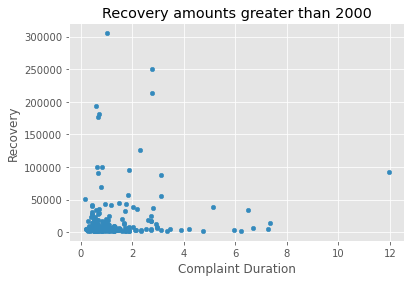

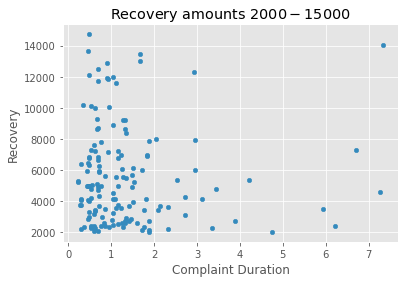

In [260]:
dt_df_2000 = dt_df[dt_df['Recovery'] > 2000]
dt_df_2000 = dt_df_2000[dt_df_2000.duplicated(subset=['File No.'], keep='first')].reset_index()

# check the records to make sure it is the one desired, then dropping it (row indices 158, 145)
recovery_max = dt_df_2000.iloc[dt_df_2000['Recovery'].idxmax()]
duration_max = dt_df_2000.iloc[dt_df_2000['Complaint Duration'].idxmax()]
dt_df_2000 = dt_df_2000.drop([145, 158])

# Graphing without outliers 
dt_df_2000.plot(kind='scatter', x='Complaint Duration', y='Recovery', title='Recovery amounts greater than 2000')

# Looking at Recovery amounts less than $15k
dt_df_15000 = dt_df[(dt_df['Recovery'] < 15000)]
dt_df_15000 = dt_df_15000[dt_df_15000['Recovery']> 2000]
dt_df_15000 = dt_df_15000[dt_df_15000['Complaint Duration'] < 40]
dt_df_15000 = dt_df_15000[dt_df_15000.duplicated(subset=['File No.'], keep='first')].reset_index()
dt_df_15000.plot(kind='scatter', x='Complaint Duration', y='Recovery', title='Recovery amounts $2000 - $15000')


In [296]:
dt_df['Recovery'].countna()

# Simplifying DF
# rec_time = dt_df[['Company', 'Recovery', 'Claim Duration']]
# rec_time.notna
# type(dt_df['Claim Duration'][0])
# import numpy as np

# (dt_df['Claim Duration'] / np.timedelta64(1, 'D')).astype(int)

AttributeError: 'Series' object has no attribute 'countna'

In [184]:
duplicate_records = ins_data[ins_data.duplicated(subset=['File No.'], keep=False)]
unique_records = ins_data[~ins_data.duplicated(subset=['File No.'], keep=False)]
# print(duplicate_records)
# print(type(unique_records))

In [74]:
company_conclus_recovery.columns

MultiIndex([('File No.',  'mean'),
            ('File No.', 'count'),
            ('Recovery',  'mean'),
            ('Recovery', 'count')],
           )

In [279]:
# need to drop nan and perhaps no authority
Conclusion_no_nan = ins_data.dropna(subset=['Conclusion'])
Conclusion_no_nan = Conclusion_no_nan[Conclusion_no_nan.duplicated(subset=['File No.'], keep='first')]
Conclusion_no_nan

,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
28,21st Century North America Insurance Company,603653,08/08/2016,09/07/2016,Auto Physical Damage,NaN,Unfair Claims Practice,Unsatisfactory Offer,Refer To Appraisal,Unjustified,0.00,Closed
46,CSAA General Insurance Company,902396,05/29/2019,06/14/2019,Homeowners,NaN,Unfair Claims Practice,Claim Procedure,Company Position Upheld,Unjustified,0.00,Closed
68,"ConnectiCare Insurance Company, Inc",902445,05/31/2019,06/14/2019,A & H,No SubCov - AH,Unfair Claims Practice,Provider Contract Issue,Claim Settled,Furnished Information,13627.00,Closed
85,"Anthem Health Plans, Inc",802630,06/06/2018,08/06/2018,Group Health,Out-Patient,Unfair Claims Practice,Denial of Claim,Company Position Upheld,Furnished Information,0.00,Closed
89,State Farm Fire & Casualty Company,801265,03/15/2018,04/02/2018,Homeowners,NaN,Underwriting,Cancellation,Cancellation Upheld,Unjustified,0.00,Closed
...,...,...,...,...,...,...,...,...,...,...,...,...
14499,"Harvard Pilgrim Health Care of Connecticut, Inc.",801423,03/22/2018,06/25/2018,Group Health,Behavl Hlth/Subst Abuse,Utilization Review,Medical Necessity,External Review Info Sent,Furnished Information,0.00,Closed
14501,Bankers Life and Casualty Company,802634,06/06/2018,06/26/2018,NaN,NaN,Unfair Claims Practice,Claim Delays,Furnished Information,Furnished Information,0.00,Closed
14504,"Anthem Health Plans, Inc",802380,05/21/2018,06/26/2018,Dental,Dental,Unfair Claims Practice,Claim Procedure,Claim Settled,Furnished Information,804.50,Closed
14505,Cigna Health and Life Insurance Company,701453,03/24/2017,05/22/2017,Group Health,Autism,Unfair Claims Practice,Eligibility of Provider,No Cause For Action,No Action Necessary,0.00,Closed


In [298]:
# These look to be all defenses and actions that an insurance company would take, but not sure
ins_data['Disposition'].unique()

array(['Company Position Upheld', 'Insufficient Information',
       'Corrective Action', 'Coverage Granted', 'Contract Provision',
       'Furnished Information', 'Premium Refund', 'Claim Settled',
       'Refer To Appraisal', 'Rate Increase Explained',
       'Cancellation Upheld', 'Non-Renewal Upheld',
       'Additional Money Received', 'Non-Renewal Rescinded',
       'Refer-Judicial/Attorney', 'External Review Info Sent',
       'Satisfied', 'Provider Issue', 'Claim Paid With Interest',
       'Pol Restored/Reinstated', 'Enter Arbitration',
       'Underwriting Discretion', 'Record Only', 'Complaint Withdrawn',
       'Other [Enter Disposition]', 'Coverage Extended',
       'Policy Not In Force', 'No Cause For Action', 'Refer To Agency',
       'Satisfactory Explanation', 'Not Insurance Related',
       'Inter-Company Arbitration', 'Cancellation Withdrawn',
       'Coverage Denied', 'Extl Rev Info Sent/SF', 'Contract Violation',
       'Mediation', 'Rate Problem Solved', 'Federal'

In [2]:

labels = ins_data['Conclusion'].unique()
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.stripplot(x=ins_data['Conclusion'], y=ins_data['Recovery']);
ax.set_xticklabels(labels, rotation=45);

NameError: name 'ins_data' is not defined

In [283]:
company_conclus_recovery = ins_data.groupby(['Company', 'Conclusion']).agg(['mean', 'count'])
# x_ax = # Top 5 companies: Anthem Health Plans, ConnectiCare, Allstate, Geico, United
y = ('File No.', 'count')
# Want to plot sub-bars for Conclusion
sns.stripplot(x=labels, y=company_conclus_recovery[('Recovery', 'mean')])

ValueError: Grouper and axis must be same length

TypeError: invalid type promotion

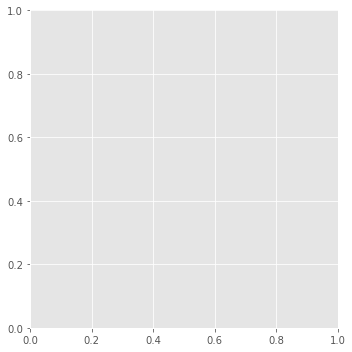

In [45]:
# Need to convert date time column to int
# Need to drop na and infinity(??) from columns
tips = sns.load_dataset("tips")
sns.catplot(x='Recovery', y='Claim Duration', data=dt_df)

import pandas
import seaborn
from matplotlib import pyplot, dates
%matplotlib inline

date = ['1975-12-03','2008-08-20', '2011-03-16']
value = [1,4,5]
df = pandas.DataFrame({
    'date': pandas.to_datetime(date),   # pandas dates
    'datenum': dates.datestr2num(date), # maptlotlib dates
    'value': value
})

@pyplot.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return dates.num2date(x).strftime('%Y-%m-%d')

fig, ax = pyplot.subplots()
# just use regplot if you don't need a FacetGrid
seaborn.regplot('datenum', 'value', data=df, ax=ax)

# here's the magic:
ax.xaxis.set_major_formatter(fake_dates)

# legible labels
ax.tick_params(labelrotation=45)

In [304]:
# It appears that the majority of complaints with a payout were considered justified or Furnished information 

x = ins_data[ins_data['Recovery'] > 0]
x['Conclusion'].value_counts()

Justified                1073
Furnished Information     520
Unjustified               360
Voluntary Reconsider      309
Questionable              137
Name: Conclusion, dtype: int64

In [4]:
ins_data['Company'].value_counts()

Anthem Health Plans, Inc                           1475
ConnectiCare Insurance Company, Inc                 598
Allstate Fire and Casualty Insurance Company        516
GEICO General Insurance Company                     340
UnitedHealthcare Insurance Company                  336
                                                   ... 
Transportation Insurance Company                      1
North Light Specialty Insurance Company               1
Columbian Mutual Life Insurance Company               1
John Alden Life Insurance Company                     1
American Empire Surplus Lines Insurance Company       1
Name: Company, Length: 623, dtype: int64

In [5]:
1475/14509

0.10166103797642842

In [7]:
ins_data['SubReason'].nunique()

69

In [ ]:
|